In [1]:
import numpy as np # 선형대수 모듈
import matplotlib.pyplot as plt # 시각화 모듈
import torch # 파이토치
import torch.nn as nn # PyTorch의 모듈을 모아놓은 것. from~~이 아닌 저렇게 임포트를 하는 것이 거의 관습이라고 한다.
import torch.nn.functional as F # torch.nn 중에서 자주 쓰는 함수를 F로 임포트.
import torch.nn.init as init # 초기화 관련 모듈 
import torchvision # TorchVision 임포트
from torchvision import transforms, datasets # 데이터를 다루기 위한 TorchVision 내의 Transforms와 datasets를 따로 임포트

In [2]:
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

BATCH_SIZE = 32
EPOCHS = 30

print('Using PyTorch version: ', torch.__version__, 'Device: ', DEVICE)
#cuda 적용

Using PyTorch version:  2.1.2 Device:  cpu


In [3]:
train_dataset = datasets.MNIST(
    root="../data/MNIST",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_dataset = datasets.MNIST(
    root="../data/MNIST",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)
#Test는 train을 false로 해준다
#미니 배치 사이즈는 32로 설정

In [4]:
for (X_train, y_train) in train_loader:
    print('X_train: ', X_train.size(), 'type: ', X_train.type())
    print('y_train: ', y_train.size(), 'type: ', y_train.type())
    break
#32개 당 하나의 mini batch
#28 * 28 pizel (하나의 손글씨 그림의 크기)

X_train:  torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor


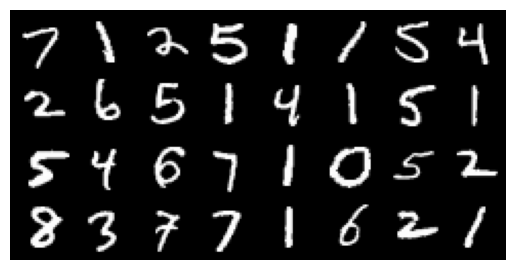

In [10]:
def imshow(img):
    # img = img / 2 + 0.5     # denormalize
    npimg = img.numpy() #텐서를 Numpy 배열로 변환
    plt.axis('off') #축을 숨긴다
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
#데이터셋을 미니배치로 나누어 제공하여, 이를 반복자로 만들어 데이터를 순차적으로 가져올수 있게 한다
try:
    images, labels = next(dataiter) #다음 미니 배치를 가져온다
    imshow(torchvision.utils.make_grid(images))
    #이미지를 그리드 형태로 정렬하여 하나의 이미지로
except StopIteration:
    # 반복자가 소진되었을 때 처리할 내용이 있다면 추가하세요.
    pass

In [11]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__() #부모 클래스의 생성자를 실행
        self.fc1 = nn.Linear(28 * 28, 512) #첫 번째 fully-connected layer
        self.fc2 = nn.Linear(512, 256) #두 번째 fully-connected layer
        self.fc3 = nn.Linear(256, 10) #세 번째 fully-connected layer
        self.dropout_prob = 0.5 # 50%의 노드에 대한 가중치 계산을 하지 않기 위한 설정
        self.batch_norm1 = nn.BatchNorm1d(512) # 1dimension이기 때문에 BatchNorm1d를 사용함.
        self.batch_norm2 = nn.BatchNorm1d(256)
        # 배치 정규화 : 입력값이 한쪽으로 쏠리거나 너무 퍼지거나 너무 좁아지지 않게

    def forward(self, x): #순전파
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.batch_norm1(x) #첫 번째 fully-connected layer를 통과
        x = F.relu(x) # sigmoid(x)
        x = F.dropout(x, training=self.training, p=self.dropout_prob)
        x = self.fc2(x)
        x = self.batch_norm2(x) #두 번째 fully-connected layer를 통과
        x = F.relu(x) # sigmoid(x)
        x = F.dropout(x, training=self.training, p=self.dropout_prob)
        x = self.fc3(x) #세 번째 fully-connected layer를 통과
        x = F.log_softmax(x, dim=1) #로그 소프트맥스 함수를 사용하여 확률로 변환
        return x

In [13]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)

model = MLP().to(DEVICE) # 정의한 모델을 GPU로 납치
model.apply(weight_init)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# print(model)

In [14]:
# 이미지와 라벨 GPU로 납치
def train(model, train_loader, optimizer, log_interval):
    model.train() # 모델 내부의 학습관련 파라미터 활성화
    for batch_idx, (image, label) in enumerate(train_loader): #미니베치를 하나씩 가져오는 반복문
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad() #이전에 계산되었던 gradient를 이용하지 않게
        output = model(image)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step() #역전파 수행하여 gradient 계산

In [15]:
# 검증단계
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += loss_fn(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [16]:
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval=100)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %".format(
        Epoch, test_loss, test_accuracy
    ))

[EPOCH: 1], 	Test Loss: 0.0039, 	Test Accuracy: 96.15 %
[EPOCH: 2], 	Test Loss: 0.0034, 	Test Accuracy: 96.62 %
[EPOCH: 3], 	Test Loss: 0.0028, 	Test Accuracy: 97.18 %
[EPOCH: 4], 	Test Loss: 0.0029, 	Test Accuracy: 96.95 %
[EPOCH: 5], 	Test Loss: 0.0028, 	Test Accuracy: 97.27 %
[EPOCH: 6], 	Test Loss: 0.0022, 	Test Accuracy: 97.92 %
[EPOCH: 7], 	Test Loss: 0.0022, 	Test Accuracy: 97.68 %
[EPOCH: 8], 	Test Loss: 0.0022, 	Test Accuracy: 97.77 %
[EPOCH: 9], 	Test Loss: 0.0021, 	Test Accuracy: 97.92 %
[EPOCH: 10], 	Test Loss: 0.0023, 	Test Accuracy: 97.98 %
[EPOCH: 11], 	Test Loss: 0.0020, 	Test Accuracy: 98.08 %
[EPOCH: 12], 	Test Loss: 0.0021, 	Test Accuracy: 98.01 %
[EPOCH: 13], 	Test Loss: 0.0020, 	Test Accuracy: 98.09 %
[EPOCH: 14], 	Test Loss: 0.0021, 	Test Accuracy: 97.95 %
[EPOCH: 15], 	Test Loss: 0.0020, 	Test Accuracy: 98.23 %
[EPOCH: 16], 	Test Loss: 0.0021, 	Test Accuracy: 98.10 %
[EPOCH: 17], 	Test Loss: 0.0020, 	Test Accuracy: 98.25 %
[EPOCH: 18], 	Test Loss: 0.0019, 	Test A